# Tumor Segmentation with FDR Control

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/tumor-segmentation.ipynb)

This notebook demonstrates conformal FDR control for tumor segmentation using the generic conformal risk control framework.

In [8]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.transform import rescale, resize
import seaborn as sns
import time
from scipy.stats import norm

# Import generic conformal risk control
# Add parent directory to path
sys.path.insert(0, '..')
from generic import GenericConformalRiskControl, GenericStabilityEstimator

!pip install -U --no-cache-dir gdown --pre


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [9]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
    
data = np.load('../data/polyps/polyps-pranet.npz')
example_paths = os.listdir('../data/polyps/examples')

sgmd = data['sgmd']  # sigmoid scores
gt_masks = data['targets']
example_indexes = data['example_indexes']

In [10]:
# Problem setup
n = 500  # number of calibration points
alpha = 0.1  # target FDR level
delta = 0.1  # LTT failure probability

# Debug mode: Set to True for faster debugging, False for full experiments
DEBUG_MODE = True

if DEBUG_MODE:
    # Fast parameters for debugging
    theta_grid = np.linspace(0, 1, 100)  # Reduced from 1000
    n_replicates = 10  # Reduced from 100
    thetas_viz = np.linspace(0, 1, 100)  # For visualization
    print("🐛 DEBUG MODE: Using reduced parameters for faster execution")
    print(f"   - theta_grid: {len(theta_grid)} points (vs 1000)")
    print(f"   - n_replicates: {n_replicates} (vs 100)")
else:
    # Full parameters for production runs
    theta_grid = np.linspace(0, 1, 1000)
    n_replicates = 100
    thetas_viz = np.linspace(0, 1, 200)
    print("🚀 PRODUCTION MODE: Using full parameters")

🐛 DEBUG MODE: Using reduced parameters for faster execution
   - theta_grid: 20 points (vs 1000)
   - n_replicates: 10 (vs 100)


In [11]:
# Split into calibration and validation sets
idx = np.array([1] * n + [0] * (sgmd.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_sgmd, val_sgmd = sgmd[idx,:], sgmd[~idx,:]
cal_gt_masks, val_gt_masks = gt_masks[idx], gt_masks[~idx]

## FDR Loss Function and Application Function

We define the FDR loss function compatible with `GenericConformalRiskControl`.

In [12]:
def fdr_loss(X_scores, Y_masks, theta):
    """
    Compute FDR loss for tumor segmentation.
    
    Parameters
    ----------
    X_scores : np.ndarray, shape (n, h, w)
        Sigmoid scores for each pixel
    Y_masks : np.ndarray, shape (n, h, w)
        Ground truth masks
    theta : float
        Threshold value (predict positive if score >= theta)
    
    Returns
    -------
    fdr : float or np.ndarray
        FDR for each example (1 - precision)
    """
    # Predict positive where score >= theta
    pred_masks = (X_scores >= theta).astype(float)
    
    # Compute true positives and total predictions per image
    tp = (pred_masks * Y_masks).sum(axis=-1).sum(axis=-1)  # shape: (n,)
    predicted_positives = pred_masks.sum(axis=-1).sum(axis=-1)  # shape: (n,)
    
    # Precision = TP / (TP + FP) = TP / predicted_positives
    # FDR = 1 - precision
    # If no pixels predicted, set FDR = 0 (no false discoveries possible)
    precision = np.where(predicted_positives > 0, tp / predicted_positives, 1.0)
    fdr = 1 - precision
    
    return fdr


def apply_ltt_fdr_control(cal_sgmd, cal_gt_masks, val_sgmd, val_gt_masks,
                           alpha=0.1, delta=0.1, theta_grid=None, verbose=True):
    """
    Apply LTT (Learn Then Test) method for FDR control using CLT.
    
    Uses the Central Limit Theorem to construct upper confidence bounds on FDR.
    For empirical FDR R̂(θ) with n samples:
        R̂(θ) ≈ N(R(θ), σ²/n)
        Upper bound: R̂(θ) + z_{1-δ} * σ/√n
    
    Parameters
    ----------
    cal_sgmd : np.ndarray, shape (n_cal, h, w)
        Sigmoid scores for calibration set
    cal_gt_masks : np.ndarray, shape (n_cal, h, w)
        Ground truth masks for calibration set
    val_sgmd : np.ndarray, shape (n_val, h, w)
        Sigmoid scores for validation set
    val_gt_masks : np.ndarray, shape (n_val, h, w)
        Ground truth masks for validation set
    alpha : float
        Target FDR level
    delta : float
        Failure probability for high-probability bound
    theta_grid : np.ndarray, optional
        Grid of threshold values to search
    verbose : bool
        Print results
    
    Returns
    -------
    results : dict
        Dictionary containing results
    """
    if theta_grid is None:
        theta_grid = np.linspace(0, 1, 1000)
    
    n = len(cal_sgmd)
    z = norm.ppf(1 - delta)  # Quantile of standard normal for (1-δ) confidence
    
    if verbose:
        print(f"LTT: Using CLT with delta={delta}, z_{1-delta:.3f}={z:.3f}")
    
    # Helper function to compute upper bound using CLT
    def fdr_upper_bound_clt(theta):
        """Compute upper bound on FDR using CLT"""
        fdr_vals = fdr_loss(cal_sgmd, cal_gt_masks, theta)
        emp_fdr = fdr_vals.mean()
        
        # Estimate standard deviation
        # Conservative approach: use empirical std
        sigma_hat = fdr_vals.std()
        
        # If sigma is very small or we have few samples, use conservative bound
        if sigma_hat < 1e-6:
            sigma_hat = 0.5  # Maximum std for [0,1] bounded loss
        
        # CLT upper bound: R̂ + z * σ̂/√n
        ub = emp_fdr + z * sigma_hat / np.sqrt(n)
        
        return min(ub, 1.0)  # Clip to [0,1]
    
    # Scan from smallest to largest theta (largest to smallest set)
    # Choose the smallest theta (largest set) such that upper bound <= alpha
    theta_hat = theta_grid[-1]  # Start with most conservative (smallest set)
    
    for theta in theta_grid:
        ub = fdr_upper_bound_clt(theta)
        if ub <= alpha:
            theta_hat = theta
            break
    
    # Apply to validation set
    val_pred_masks = (val_sgmd >= theta_hat).astype(float)
    
    # Compute validation FDR
    val_fdr_per_image = fdr_loss(val_sgmd, val_gt_masks, theta_hat)
    empirical_fdr = val_fdr_per_image.mean()
    
    # Compute prediction rate (fraction of pixels predicted positive)
    prediction_rate = val_pred_masks.mean()
    
    # Compute precision (1 - FDR)
    empirical_precision = 1 - empirical_fdr
    
    if verbose:
        print(f"\nThreshold θ̂: {theta_hat:.4f}")
        print(f"Empirical FDR: {empirical_fdr:.4f}")
        print(f"Empirical precision: {empirical_precision:.4f}")
        print(f"Prediction rate (fraction of pixels selected): {prediction_rate:.4f}")
    
    results = {
        'theta_hat': theta_hat,
        'beta_hat': 0.0,  # LTT doesn't use stability estimation
        'empirical_fdr': empirical_fdr,
        'empirical_precision': empirical_precision,
        'prediction_rate': prediction_rate,
        'predicted_masks': val_pred_masks,
        'controller': None
    }
    
    return results


def apply_fdr_control_to_tumor_segmentation(cal_sgmd, cal_gt_masks, val_sgmd, val_gt_masks,
                                             alpha=0.1, theta_grid=None, 
                                             stability_method=None, LTT=False, delta=0.1,
                                             verbose=True):
    """
    Apply conformal FDR control to tumor segmentation.
    
    Parameters
    ----------
    cal_sgmd : np.ndarray, shape (n_cal, h, w)
        Sigmoid scores for calibration set
    cal_gt_masks : np.ndarray, shape (n_cal, h, w)
        Ground truth masks for calibration set
    val_sgmd : np.ndarray, shape (n_val, h, w)
        Sigmoid scores for validation set
    val_gt_masks : np.ndarray, shape (n_val, h, w)
        Ground truth masks for validation set
    alpha : float
        Target FDR level
    theta_grid : np.ndarray, optional
        Grid of threshold values to search
    stability_method : str, optional
        Method for stability estimation: 'definition', 'discretized', 'smooth', or None
    LTT : bool
        If True, use Learn Then Test approach
    delta : float
        LTT failure probability (only used when LTT=True)
    verbose : bool
        Print results
    
    Returns
    -------
    results : dict
        Dictionary containing results
    """
    if theta_grid is None:
        theta_grid = np.linspace(0, 1, 1000)
    
    # Use LTT method if requested
    if LTT:
        return apply_ltt_fdr_control(
            cal_sgmd, cal_gt_masks, val_sgmd, val_gt_masks,
            alpha=alpha, delta=delta, theta_grid=theta_grid, verbose=verbose
        )
    
    # Otherwise use conformal risk control
    beta_hat = 0.0
    if stability_method is not None:
        # Conservative CRC with stability estimation
        estimator = GenericStabilityEstimator(alpha=alpha, n_bootstrap=100)
        
        if stability_method == 'definition':
            if verbose:
                print("Estimating β from definition...")
            beta_hat = estimator.estimate_beta_def(
                cal_sgmd, cal_gt_masks, fdr_loss, theta_grid
            )
        elif stability_method == 'discretized':
            if verbose:
                print("Estimating β using discretization bound...")
            beta_hat = estimator.estimate_beta_discretized(
                n=len(cal_sgmd), m=len(theta_grid)
            )
        elif stability_method == 'smooth':
            if verbose:
                print("Estimating β using Lipschitz-slope bound...")
            beta_hat = estimator.estimate_beta_smooth(
                cal_sgmd, cal_gt_masks, fdr_loss, theta_grid
            )
        
        if verbose:
            print(f"β̂ = {beta_hat:.6f}")
        alpha_adjusted = max(0.0, alpha - beta_hat)
    else:
        # Standard CRC
        alpha_adjusted = alpha
    
    # Fit conformal risk control
    controller = GenericConformalRiskControl(alpha=alpha_adjusted, theta_grid=theta_grid)
    theta_hat = controller.fit(cal_sgmd, cal_gt_masks, fdr_loss, theta_grid)
    
    # Apply to validation set
    val_pred_masks = (val_sgmd >= theta_hat).astype(float)
    
    # Compute validation FDR
    val_fdr_per_image = fdr_loss(val_sgmd, val_gt_masks, theta_hat)
    empirical_fdr = val_fdr_per_image.mean()
    
    # Compute prediction rate (fraction of pixels predicted positive)
    prediction_rate = val_pred_masks.mean()
    
    # Compute precision (1 - FDR)
    empirical_precision = 1 - empirical_fdr
    
    if verbose:
        print(f"\nThreshold θ̂: {theta_hat:.4f}")
        print(f"Empirical FDR: {empirical_fdr:.4f}")
        print(f"Empirical precision: {empirical_precision:.4f}")
        print(f"Prediction rate (fraction of pixels selected): {prediction_rate:.4f}")
    
    results = {
        'theta_hat': theta_hat,
        'beta_hat': beta_hat,
        'empirical_fdr': empirical_fdr,
        'empirical_precision': empirical_precision,
        'prediction_rate': prediction_rate,
        'predicted_masks': val_pred_masks,
        'controller': controller
    }
    
    return results

## Three-Way Comparison: CRC-C vs CRC vs LTT

We compare conservative CRC (with stability correction) to standard CRC and LTT (Learn Then Test).

In [13]:
# CRC-C (Conservative) - with stability estimation
print("="*85)
print("CRC-C (Conservative with Stability Estimation)")
print("="*85)
time_start_crc_c = time.time()
results_conservative = apply_fdr_control_to_tumor_segmentation(
    cal_sgmd, cal_gt_masks, val_sgmd, val_gt_masks,
    alpha=alpha, theta_grid=theta_grid,
    stability_method='discretized',  # Using discretized bound for efficiency
    verbose=True
)
time_crc_c = time.time() - time_start_crc_c

# CRC (Standard)
print("\n" + "="*85)
print("CRC (Standard)")
print("="*85)
time_start_crc = time.time()
results_standard = apply_fdr_control_to_tumor_segmentation(
    cal_sgmd, cal_gt_masks, val_sgmd, val_gt_masks,
    alpha=alpha, theta_grid=theta_grid,
    stability_method=None,
    verbose=True
)
time_crc = time.time() - time_start_crc

# LTT (Learn Then Test)
print("\n" + "="*85)
print("LTT (Learn Then Test)")
print("="*85)
time_start_ltt = time.time()
results_ltt = apply_fdr_control_to_tumor_segmentation(
    cal_sgmd, cal_gt_masks, val_sgmd, val_gt_masks,
    alpha=alpha, theta_grid=theta_grid,
    LTT=True, delta=delta,
    verbose=True
)
time_ltt = time.time() - time_start_ltt

# Summary comparison
print("\n" + "="*85)
print("THREE-WAY COMPARISON")
print("="*85)
print(f"{'Metric':<40} {'CRC-C':<15} {'CRC':<15} {'LTT':<15}")
print("-"*85)
print(f"{'Threshold':<40} {results_conservative['theta_hat']:<15.4f} {results_standard['theta_hat']:<15.4f} {results_ltt['theta_hat']:<15.4f}")
print(f"{'Empirical FDR':<40} {results_conservative['empirical_fdr']:<15.4f} {results_standard['empirical_fdr']:<15.4f} {results_ltt['empirical_fdr']:<15.4f}")
print(f"{'Empirical precision':<40} {results_conservative['empirical_precision']:<15.4f} {results_standard['empirical_precision']:<15.4f} {results_ltt['empirical_precision']:<15.4f}")
print(f"{'Prediction rate':<40} {results_conservative['prediction_rate']:<15.4f} {results_standard['prediction_rate']:<15.4f} {results_ltt['prediction_rate']:<15.4f}")
print(f"{'Runtime (seconds)':<40} {time_crc_c:<15.4f} {time_crc:<15.4f} {time_ltt:<15.4f}")
print("="*85)

CRC-C (Conservative with Stability Estimation)
Estimating β using discretization bound...
β̂ = 0.071999


/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_18121/3883414501.py:29: RuntimeWarning: invalid value encountered in divide
  precision = np.where(predicted_positives > 0, tp / predicted_positives, 1.0)



Threshold θ̂: 0.7368
Empirical FDR: 0.0190
Empirical precision: 0.9810
Prediction rate (fraction of pixels selected): 0.0925

CRC (Standard)

Threshold θ̂: 0.4737
Empirical FDR: 0.0769
Empirical precision: 0.9231
Prediction rate (fraction of pixels selected): 0.1174

LTT (Learn Then Test)
LTT: Using CLT with delta=0.1, z_0.900=1.282

Threshold θ̂: 0.4737
Empirical FDR: 0.0769
Empirical precision: 0.9231
Prediction rate (fraction of pixels selected): 0.1174

THREE-WAY COMPARISON
Metric                                   CRC-C           CRC             LTT            
-------------------------------------------------------------------------------------
Threshold                                0.7368          0.4737          0.4737         
Empirical FDR                            0.0190          0.0769          0.0769         
Empirical precision                      0.9810          0.9231          0.9231         
Prediction rate                          0.0925          0.1174          0

## Visualization: FDR Curve and Comparison

/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_18121/3883414501.py:29: RuntimeWarning: invalid value encountered in divide
  precision = np.where(predicted_positives > 0, tp / predicted_positives, 1.0)


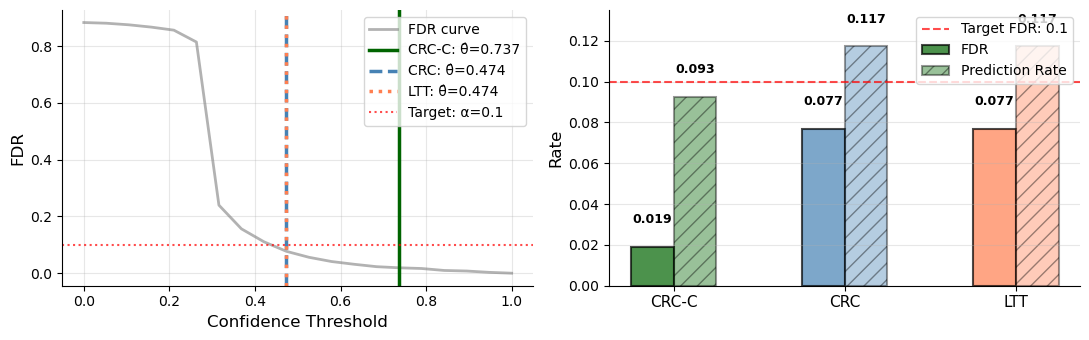

In [14]:
# Compute FDR and prediction rate curves
fdr_curve = []
prediction_rate_curve = []

for theta in thetas_viz:
    fdr_val = fdr_loss(val_sgmd, val_gt_masks, theta).mean()
    pred_rate = (val_sgmd >= theta).mean()
    fdr_curve.append(fdr_val)
    prediction_rate_curve.append(pred_rate)

fdr_curve = np.array(fdr_curve)
prediction_rate_curve = np.array(prediction_rate_curve)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

# Plot 1: FDR curve with threshold comparison
ax = axes[0]
ax.plot(thetas_viz, fdr_curve, label='FDR curve', linewidth=2, color='gray', alpha=0.6)
ax.axvline(x=results_conservative['theta_hat'], linewidth=2.5, linestyle='-', 
           label=f"CRC-C: θ̂={results_conservative['theta_hat']:.3f}", color='darkgreen')
ax.axvline(x=results_standard['theta_hat'], linewidth=2.5, linestyle='--', 
           label=f"CRC: θ̂={results_standard['theta_hat']:.3f}", color='steelblue')
ax.axvline(x=results_ltt['theta_hat'], linewidth=2.5, linestyle=':', 
           label=f'LTT: θ̂={results_ltt["theta_hat"]:.3f}', color='coral')
ax.axhline(y=alpha, linewidth=1.5, linestyle='dotted', 
           label=f'Target: α={alpha}', color='red', alpha=0.7)
ax.set_xlabel('Confidence Threshold', fontsize=12)
ax.set_ylabel('FDR', fontsize=12)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Plot 2: Performance bars
ax = axes[1]
width = 0.25
x_pos = np.arange(3)
fdrs = [results_conservative['empirical_fdr'], results_standard['empirical_fdr'], results_ltt['empirical_fdr']]
pred_rates = [results_conservative['prediction_rate'], results_standard['prediction_rate'], results_ltt['prediction_rate']]
colors_bars = ['darkgreen', 'steelblue', 'coral']
labels_bars = ['CRC-C', 'CRC', 'LTT']

bars1 = ax.bar(x_pos - width/2, fdrs, width, label='FDR',
               color=colors_bars, alpha=0.7, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, pred_rates, width, label='Prediction Rate',
               color=colors_bars, alpha=0.4, edgecolor='black', linewidth=1.5, hatch='//')

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
            f'{height1:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
            f'{height2:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.axhline(y=alpha, linewidth=1.5, linestyle='--', color='red', alpha=0.7,
           label=f'Target FDR: {alpha:.1f}')
ax.set_ylabel('Rate', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_bars, fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim([0, max(max(fdrs), max(pred_rates)) * 1.15])
ax.grid(True, alpha=0.3, axis='y')
sns.despine(ax=ax)

plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig('./plots/fdr-control-comparison.pdf', dpi=150)
plt.show()

## Multi-Replicate Experiment

To thoroughly compare the methods, we run multiple replicates with different random calibration/validation splits.

In [15]:
print(f"Running {n_replicates}-replicate experiment...")
print("This may take several minutes...\n")

results_experiment = {
    'crc_c_fdr': [],
    'crc_c_pred_rate': [],
    'crc_c_threshold': [],
    'crc_fdr': [],
    'crc_pred_rate': [],
    'crc_threshold': [],
    'ltt_fdr': [],
    'ltt_pred_rate': [],
    'ltt_threshold': []
}

for rep in range(n_replicates):
    if (rep + 1) % max(1, n_replicates // 5) == 0:
        print(f"  Completed {rep + 1}/{n_replicates} replicates...")
    
    # Random split
    idx_rep = np.array([1] * n + [0] * (sgmd.shape[0] - n)) > 0
    np.random.shuffle(idx_rep)
    
    cal_sgmd_rep = sgmd[idx_rep, :]
    val_sgmd_rep = sgmd[~idx_rep, :]
    cal_gt_masks_rep = gt_masks[idx_rep]
    val_gt_masks_rep = gt_masks[~idx_rep]
    
    # CRC-C
    res_crc_c = apply_fdr_control_to_tumor_segmentation(
        cal_sgmd_rep, cal_gt_masks_rep, val_sgmd_rep, val_gt_masks_rep,
        alpha=alpha, theta_grid=theta_grid,
        stability_method='discretized', verbose=False
    )
    results_experiment['crc_c_fdr'].append(res_crc_c['empirical_fdr'])
    results_experiment['crc_c_pred_rate'].append(res_crc_c['prediction_rate'])
    results_experiment['crc_c_threshold'].append(res_crc_c['theta_hat'])
    
    # CRC
    res_crc = apply_fdr_control_to_tumor_segmentation(
        cal_sgmd_rep, cal_gt_masks_rep, val_sgmd_rep, val_gt_masks_rep,
        alpha=alpha, theta_grid=theta_grid,
        stability_method=None, verbose=False
    )
    results_experiment['crc_fdr'].append(res_crc['empirical_fdr'])
    results_experiment['crc_pred_rate'].append(res_crc['prediction_rate'])
    results_experiment['crc_threshold'].append(res_crc['theta_hat'])
    
    # LTT
    res_ltt = apply_fdr_control_to_tumor_segmentation(
        cal_sgmd_rep, cal_gt_masks_rep, val_sgmd_rep, val_gt_masks_rep,
        alpha=alpha, theta_grid=theta_grid,
        LTT=True, delta=delta, verbose=False
    )
    results_experiment['ltt_fdr'].append(res_ltt['empirical_fdr'])
    results_experiment['ltt_pred_rate'].append(res_ltt['prediction_rate'])
    results_experiment['ltt_threshold'].append(res_ltt['theta_hat'])

# Convert to arrays
for key in results_experiment:
    results_experiment[key] = np.array(results_experiment[key])

print(f"✓ Completed all {n_replicates} replicates!\n")

# Summary statistics
print("=" * 85)
print(f"{n_replicates}-REPLICATE EXPERIMENT RESULTS")
print("=" * 85)
print(f"{'Metric':<35} {'CRC-C':<16} {'CRC':<16} {'LTT':<16}")
print("-" * 85)
print(f"{'Mean FDR':<35} {results_experiment['crc_c_fdr'].mean():<16.4f} {results_experiment['crc_fdr'].mean():<16.4f} {results_experiment['ltt_fdr'].mean():<16.4f}")
print(f"{'Std FDR':<35} {results_experiment['crc_c_fdr'].std():<16.4f} {results_experiment['crc_fdr'].std():<16.4f} {results_experiment['ltt_fdr'].std():<16.4f}")
print(f"{'Mean Prediction Rate':<35} {results_experiment['crc_c_pred_rate'].mean():<16.4f} {results_experiment['crc_pred_rate'].mean():<16.4f} {results_experiment['ltt_pred_rate'].mean():<16.4f}")
print(f"{'Std Prediction Rate':<35} {results_experiment['crc_c_pred_rate'].std():<16.4f} {results_experiment['crc_pred_rate'].std():<16.4f} {results_experiment['ltt_pred_rate'].std():<16.4f}")
print(f"{'Mean Threshold':<35} {results_experiment['crc_c_threshold'].mean():<16.4f} {results_experiment['crc_threshold'].mean():<16.4f} {results_experiment['ltt_threshold'].mean():<16.4f}")
print(f"{'Std Threshold':<35} {results_experiment['crc_c_threshold'].std():<16.4f} {results_experiment['crc_threshold'].std():<16.4f} {results_experiment['ltt_threshold'].std():<16.4f}")
print("-" * 85)
print(f"{'FDR violations (> α)':<35} {(results_experiment['crc_c_fdr'] > alpha).sum():<16} {(results_experiment['crc_fdr'] > alpha).sum():<16} {(results_experiment['ltt_fdr'] > alpha).sum():<16}")
print(f"{'Violation rate':<35} {100*(results_experiment['crc_c_fdr'] > alpha).mean():<15.1f}% {100*(results_experiment['crc_fdr'] > alpha).mean():<15.1f}% {100*(results_experiment['ltt_fdr'] > alpha).mean():<15.1f}%")
print("=" * 85)

Running 10-replicate experiment...
This may take several minutes...



/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_18121/3883414501.py:29: RuntimeWarning: invalid value encountered in divide
  precision = np.where(predicted_positives > 0, tp / predicted_positives, 1.0)


  Completed 2/10 replicates...
  Completed 4/10 replicates...
  Completed 6/10 replicates...
  Completed 8/10 replicates...
  Completed 10/10 replicates...
✓ Completed all 10 replicates!

10-REPLICATE EXPERIMENT RESULTS
Metric                              CRC-C            CRC              LTT             
-------------------------------------------------------------------------------------
Mean FDR                            0.0231           0.0763           0.0722          
Std FDR                             0.0030           0.0027           0.0105          
Mean Prediction Rate                0.0969           0.1177           0.1168          
Std Prediction Rate                 0.0034           0.0020           0.0024          
Mean Threshold                      0.7000           0.4737           0.4842          
Std Threshold                       0.0241           0.0000           0.0211          
-------------------------------------------------------------------------------------

## Distribution Comparison (KDE Plots)

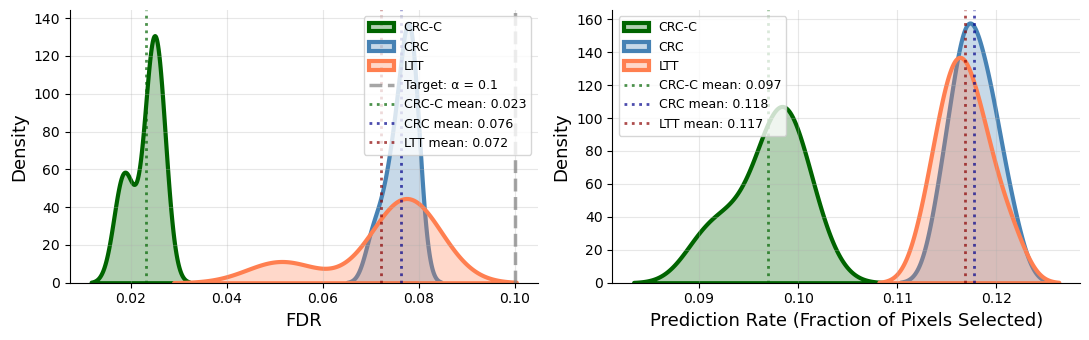


STATISTICAL ANALYSIS

📊 FDR:
  • CRC-C: 0.0231 ± 0.0030
  • CRC:   0.0763 ± 0.0027
  • LTT:   0.0722 ± 0.0105
  • Violations (FDR > α):
    - CRC-C: 0/10 (0.0%)
    - CRC:   0/10 (0.0%)
    - LTT:   0/10 (0.0%)

📊 Prediction Rate:
  • CRC-C: 0.0969 ± 0.0034
  • CRC:   0.1177 ± 0.0020
  • LTT:   0.1168 ± 0.0024
  • CRC selects 21.4% more pixels than CRC-C on average


In [16]:
# KDE plots comparing distributions
fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

# Plot 1: FDR Distribution
ax = axes[0]
sns.kdeplot(results_experiment['crc_c_fdr'], ax=ax, label='CRC-C',
            color='darkgreen', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_fdr'], ax=ax, label='CRC',
            color='steelblue', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_fdr'], ax=ax, label='LTT',
            color='coral', linewidth=3, fill=True, alpha=0.3)
ax.axvline(x=alpha, linewidth=2.5, linestyle='--', color='gray',
           label=f'Target: α = {alpha}', alpha=0.7)

# Add mean lines
ax.axvline(x=results_experiment['crc_c_fdr'].mean(), linewidth=2,
           linestyle=':', color='darkgreen', alpha=0.7,
           label=f"CRC-C mean: {results_experiment['crc_c_fdr'].mean():.3f}")
ax.axvline(x=results_experiment['crc_fdr'].mean(), linewidth=2,
           linestyle=':', color='darkblue', alpha=0.7,
           label=f"CRC mean: {results_experiment['crc_fdr'].mean():.3f}")
ax.axvline(x=results_experiment['ltt_fdr'].mean(), linewidth=2,
           linestyle=':', color='darkred', alpha=0.7,
           label=f"LTT mean: {results_experiment['ltt_fdr'].mean():.3f}")

ax.set_xlabel('FDR', fontsize=13)
ax.set_ylabel('Density', fontsize=13)
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Plot 2: Prediction Rate Distribution
ax = axes[1]
sns.kdeplot(results_experiment['crc_c_pred_rate'], ax=ax, label='CRC-C',
            color='darkgreen', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_pred_rate'], ax=ax, label='CRC',
            color='steelblue', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_pred_rate'], ax=ax, label='LTT',
            color='coral', linewidth=3, fill=True, alpha=0.3)

# Add mean lines
ax.axvline(x=results_experiment['crc_c_pred_rate'].mean(), linewidth=2,
           linestyle=':', color='darkgreen', alpha=0.7,
           label=f"CRC-C mean: {results_experiment['crc_c_pred_rate'].mean():.3f}")
ax.axvline(x=results_experiment['crc_pred_rate'].mean(), linewidth=2,
           linestyle=':', color='darkblue', alpha=0.7,
           label=f"CRC mean: {results_experiment['crc_pred_rate'].mean():.3f}")
ax.axvline(x=results_experiment['ltt_pred_rate'].mean(), linewidth=2,
           linestyle=':', color='darkred', alpha=0.7,
           label=f"LTT mean: {results_experiment['ltt_pred_rate'].mean():.3f}")

ax.set_xlabel('Prediction Rate (Fraction of Pixels Selected)', fontsize=13)
ax.set_ylabel('Density', fontsize=13)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('./plots/fdr-control-kde-distributions.pdf', dpi=150)
plt.show()

# Statistical comparison
print("\n" + "=" * 85)
print("STATISTICAL ANALYSIS")
print("=" * 85)

print(f"\n📊 FDR:")
print(f"  • CRC-C: {results_experiment['crc_c_fdr'].mean():.4f} ± {results_experiment['crc_c_fdr'].std():.4f}")
print(f"  • CRC:   {results_experiment['crc_fdr'].mean():.4f} ± {results_experiment['crc_fdr'].std():.4f}")
print(f"  • LTT:   {results_experiment['ltt_fdr'].mean():.4f} ± {results_experiment['ltt_fdr'].std():.4f}")

fdr_above_target_crc_c = (results_experiment['crc_c_fdr'] > alpha).sum()
fdr_above_target_crc = (results_experiment['crc_fdr'] > alpha).sum()
fdr_above_target_ltt = (results_experiment['ltt_fdr'] > alpha).sum()
print(f"  • Violations (FDR > α):")
print(f"    - CRC-C: {fdr_above_target_crc_c}/{n_replicates} ({100*fdr_above_target_crc_c/n_replicates:.1f}%)")
print(f"    - CRC:   {fdr_above_target_crc}/{n_replicates} ({100*fdr_above_target_crc/n_replicates:.1f}%)")
print(f"    - LTT:   {fdr_above_target_ltt}/{n_replicates} ({100*fdr_above_target_ltt/n_replicates:.1f}%)")

print(f"\n📊 Prediction Rate:")
print(f"  • CRC-C: {results_experiment['crc_c_pred_rate'].mean():.4f} ± {results_experiment['crc_c_pred_rate'].std():.4f}")
print(f"  • CRC:   {results_experiment['crc_pred_rate'].mean():.4f} ± {results_experiment['crc_pred_rate'].std():.4f}")
print(f"  • LTT:   {results_experiment['ltt_pred_rate'].mean():.4f} ± {results_experiment['ltt_pred_rate'].std():.4f}")

if results_experiment['crc_pred_rate'].mean() > results_experiment['crc_c_pred_rate'].mean():
    diff_pct = 100 * (results_experiment['crc_pred_rate'].mean() - results_experiment['crc_c_pred_rate'].mean()) / results_experiment['crc_c_pred_rate'].mean()
    print(f"  • CRC selects {diff_pct:.1f}% more pixels than CRC-C on average")

## Example Visualizations

Showing example segmentations with threshold θ̂ = 0.7368



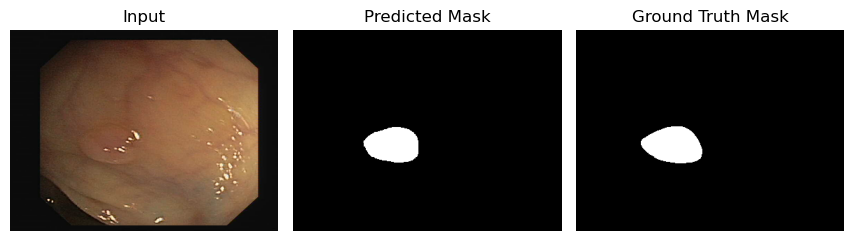

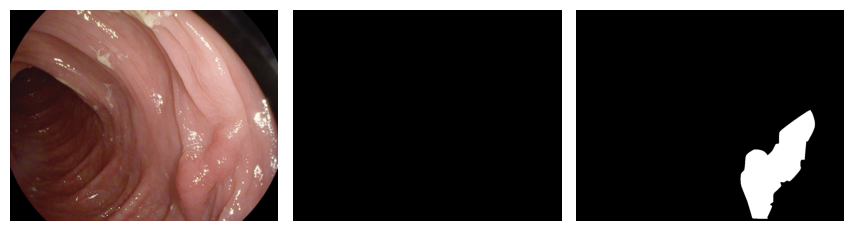

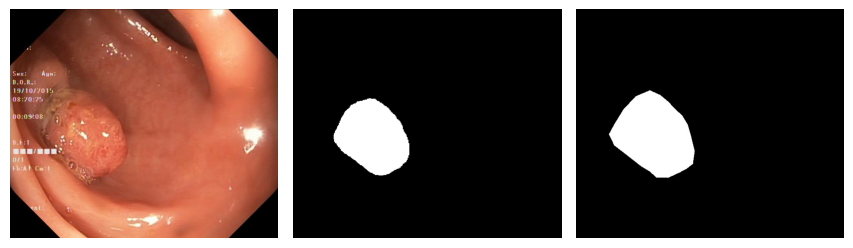

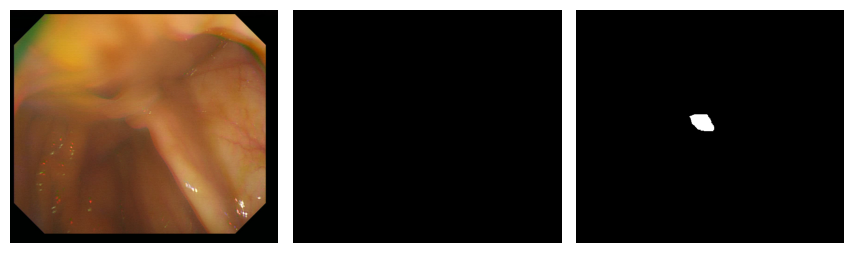

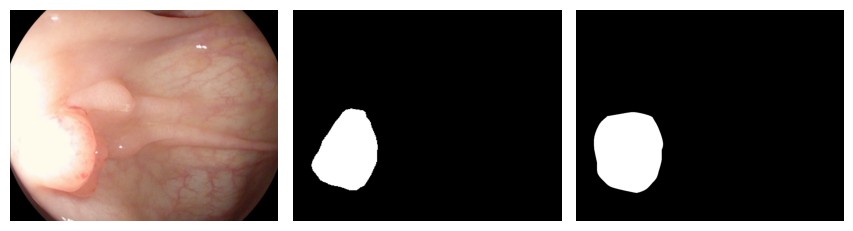

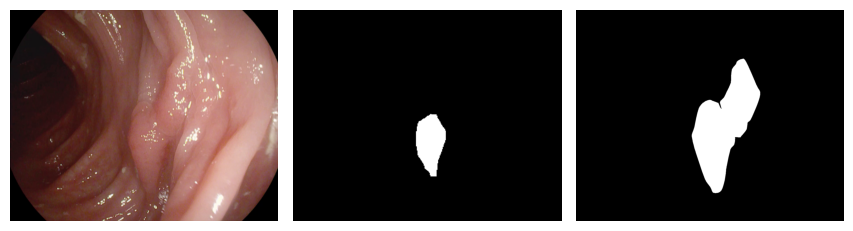

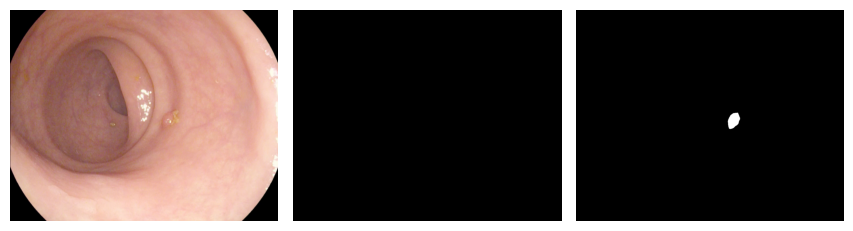

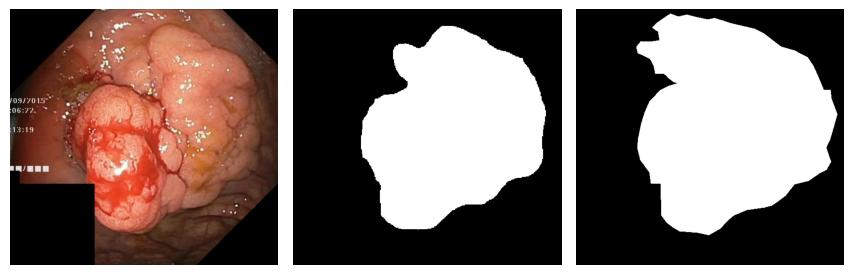

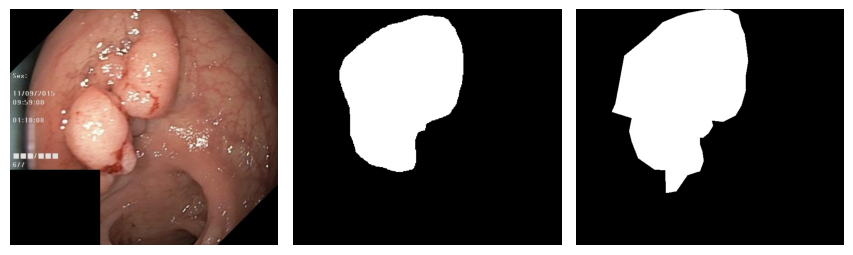

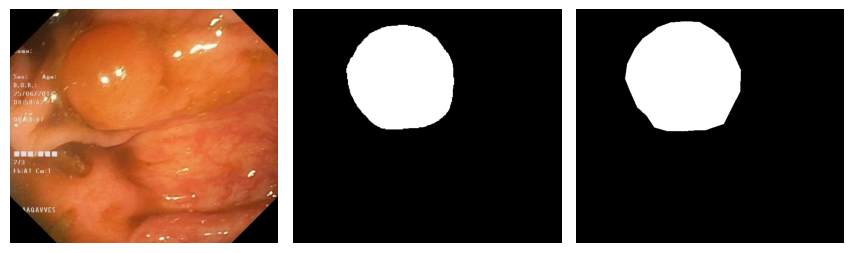

In [17]:
# Show some example segmentations using the conservative threshold
theta_final = results_conservative['theta_hat']

print(f"Showing example segmentations with threshold θ̂ = {theta_final:.4f}\n")

for i in range(10):
    rand_idx = np.random.choice(example_indexes)
    img = imread('../data/polyps/examples/' + str(rand_idx) + '.jpg')
    gt_mask = imread('../data/polyps/examples/' + str(rand_idx) + '_gt_mask.jpg')
    predicted_mask = resize(sgmd[rand_idx] >= theta_final, 
                           (img.shape[0], img.shape[1]), 
                           anti_aliasing=False)
    
    fig, axs = plt.subplots(1, 3, figsize=(8.64, 4.76))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(gt_mask, cmap='gray')
    axs[2].axis('off')
    
    if i == 0:
        axs[0].set_title('Input')
        axs[1].set_title('Predicted Mask')
        axs[2].set_title('Ground Truth Mask')
    
    plt.tight_layout()
    plt.show()

## Summary

This notebook demonstrates conformal FDR control for tumor segmentation using the generic conformal risk control framework from `generic.py`. The algorithm selects the largest set of pixels (smallest threshold) that achieves the FDR guarantee.

Key comparisons:
- **CRC-C** (Conservative): Uses stability estimation with discretization bound for robust FDR control
- **CRC** (Standard): Standard conformal risk control without stability correction
- **LTT** (Learn Then Test): Uses Hoeffding-style concentration bound with failure probability δ

All methods control FDR at the target level α, with different trade-offs:
- CRC-C is most conservative, providing stronger guarantees under distribution shift
- CRC achieves higher prediction rates with standard conformal guarantees
- LTT provides distribution-free guarantees with explicit failure probability

Reference: Angelopoulos, A. N. et al. (2022). "Conformal Risk Control." arXiv:2208.02814